# 逻辑回归实战01
根据学生两门课的成绩，判断学生是否能通过测试

In [2]:
import pandas as pd

In [3]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
df = pd.read_csv('data/ex2data1.txt',header=None)
df.columns=['class1','class2','pass']

In [167]:
df.head()

,class1,class2,pass
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


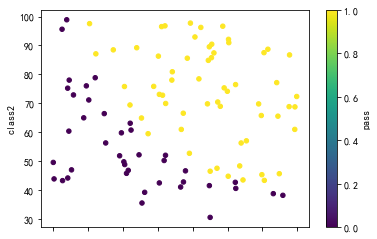

In [168]:
df.plot(kind='scatter',x='class1',y='class2',c='pass',cmap='viridis')

In [169]:
import tensorflow as tf
from tensorflow.contrib import slim

x_data = df[['class1','class2']].values
y_data = df[['pass']].values

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
#     下面这几行代码是如果自己手动写，要怎么写，和下面用slim写的是等价的
#     W = tf.Variable(tf.random_normal([2,1]))
#     b = tf.Variable(tf.random_normal([1,1]))
#     y_predict = tf.matmul(x_placeholder,W)+b
    #####################################################
    y_predict = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
    #####################################################
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        if i%10000==0:
            var_list =tf.get_collection('trainable_variables',scope='network')+[loss]
            _ = sess.run(var_list,feed_dict={x_placeholder:x_data,y_placeholder:y_data})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    #后续作图准备
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(0,100,101)
    y = np.linspace(0,100,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})

[array([[ 0.3757934 ],
       [-0.51759624]], dtype=float32), array([0.7306016], dtype=float32), 7.5186114]
[array([[0.06604161],
       [0.05953157]], dtype=float32), array([-7.519258], dtype=float32), 0.3150997]
[array([[0.13268252],
       [0.12695749]], dtype=float32), array([-15.95037], dtype=float32), 0.22181107]
[array([[0.19406368],
       [0.18915717]], dtype=float32), array([-23.639708], dtype=float32), 0.20386083]
[array([[0.20623168],
       [0.20147157]], dtype=float32), array([-25.16134], dtype=float32), 0.20349766]
[array([[0.2062324 ],
       [0.20147227]], dtype=float32), array([-25.161417], dtype=float32), 0.20349774]
[array([[0.20623997],
       [0.20147985]], dtype=float32), array([-25.16143], dtype=float32), 0.20349774]
[array([[0.20623237],
       [0.20147225]], dtype=float32), array([-25.16142], dtype=float32), 0.20349774]
[array([[0.20623244],
       [0.20147233]], dtype=float32), array([-25.16142], dtype=float32), 0.2034977]
[array([[0.20623256],
       [0.2014

(30, 100)

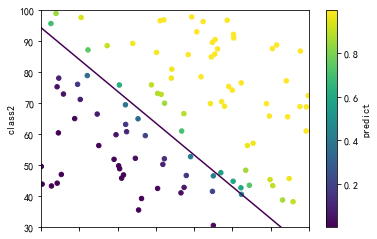

In [170]:
df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(30,100)
plt.ylim(30,100)

In [171]:
df.head()

,class1,class2,pass,predict
0,34.623660,78.024693,0,0.090075
1,30.286711,43.894998,0,0.000042
2,35.847409,72.902198,0,0.043439
3,60.182599,86.308552,1,0.990281
4,79.032736,75.344376,1,0.998170


分割线是WX+b=0，也就是0.20623253*class1+0.20147243*class2-25.16144=0，这条直线就是分割线，分割了两类考生

# 逻辑回归实战02
此任务基于ex2data2.txt数据集的代码实现，ex2data2.txt数据集与ex2data1.txt数据集的格式基本一致，代码实现的流程上一致，不同处是特征提取和边界函数的图像绘制上。
在ex2data1.txt数据集中边界函数是一个一元一次函数，因此，基于ex2data1.txt数据集画边界函数非常简单。而在ex2data2.txt数据集中我们要预设的边界函数是一个高阶函数，因此再使用上面的代码不能绘制出高阶函数的曲线，此外，在此案例中，两个特征不能满足边界函数的要求，需要通过数据集中的数据计算出多个新的特征，以满足边界函数的要求。这是此案例中要解决的两个难点。

In [4]:
df = pd.read_csv('data/ex2data2.txt',header=None)
df.columns=['class1','class2','pass']

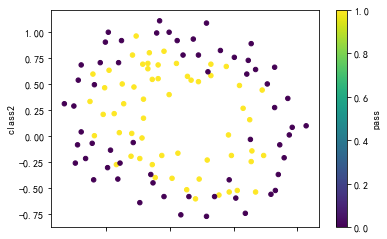

In [5]:
df.plot(kind='scatter',x='class1',y='class2',c='pass',cmap='viridis')

In [9]:
import tensorflow as tf
from tensorflow.contrib import slim

x_data = df[['class1','class2']].values
y_data = df[['pass']].values

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
#     W = tf.Variable(tf.random_normal([2,1]))
#     b = tf.Variable(tf.random_normal([1,1]))
#     y_predict = tf.matmul(x_placeholder,W)+b
    y_predict = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        if i%10000==0:
            var_list =tf.get_collection('trainable_variables',scope='network')+[loss]
            _ = sess.run(var_list,feed_dict={x_placeholder:x_data,y_placeholder:y_data})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})

[array([[-0.74088323],
       [ 1.0360608 ]], dtype=float32), array([0.4907411], dtype=float32), 0.7868959]
[array([[-0.30352116],
       [-0.01813178]], dtype=float32), array([-0.0141842], dtype=float32), 0.69024116]
[array([[-0.30352262],
       [-0.0181339 ]], dtype=float32), array([-0.01418649], dtype=float32), 0.69024104]
[array([[-0.30352113],
       [-0.01813099]], dtype=float32), array([-0.01418287], dtype=float32), 0.69024116]
[array([[-0.30356297],
       [-0.01817384]], dtype=float32), array([-0.01422629], dtype=float32), 0.6902411]
[array([[-0.30352178],
       [-0.01813124]], dtype=float32), array([-0.01418336], dtype=float32), 0.69024116]
[array([[-0.3035215 ],
       [-0.01813188]], dtype=float32), array([-0.01418274], dtype=float32), 0.6902411]
[array([[-0.30352113],
       [-0.01813167]], dtype=float32), array([-0.01418304], dtype=float32), 0.6902411]
[array([[-0.30353963],
       [-0.01815367]], dtype=float32), array([-0.01420495], dtype=float32), 0.6902411]
[array([[

(-1, 1)

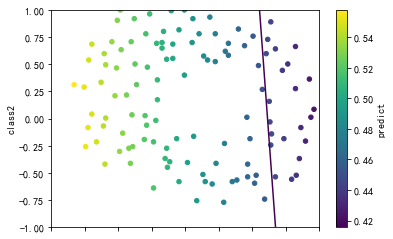

In [10]:
df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [47]:
import tensorflow as tf
from tensorflow.contrib import slim

x_data = df[['class1','class2']].values
y_data = df[['pass']].values

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #####################################################
    #增加了sigmoid为激活函数的隐藏层
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=3, # 这个地方神经元的个数怎么来的？？？
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer,scope='hidden_layer')
    #####################################################
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        if i%10000==0:
#             var_list =tf.get_collection('trainable_variables',scope='network')+[loss]
            _ = sess.run(loss,feed_dict={x_placeholder:x_data,y_placeholder:y_data})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

0.695479
0.444692
0.38587135
0.34929916
0.33740705
0.33213437
0.32973254
0.3286818
0.3282636
0.32807797
finish train


In [48]:
tf.get_collection('trainable_variables',scope='network')

[<tf.Variable 'network/hidden_layer/weights:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'network/hidden_layer/biases:0' shape=(3,) dtype=float32_ref>,
 <tf.Variable 'network/fully_connected/weights:0' shape=(3, 1) dtype=float32_ref>,
 <tf.Variable 'network/fully_connected/biases:0' shape=(1,) dtype=float32_ref>]

(-1, 1)

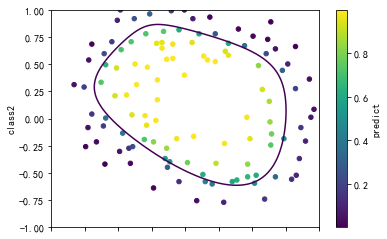

In [16]:
df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [17]:
df['p_label']=df['predict'].apply(lambda x:0 if x<0.5 else 1)

In [18]:
print('错误率：',(df['pass'] != df['p_label']).sum()/len(df))

错误率： 0.15254237288135594


## 过拟合问题

多层的神经网络可以更好的学习到数据集中的信息，但过于复杂的神经网络却又将带来另一个问题：过于强大的学习能力将导致神经网络学习到仅仅属于训练数据的特征。

过拟合的检测：我们可以将训练数据人工的分成两部分，一部分用作训练，另一部分用于检测训练的效果，神经网络将不会学习到用于检测的数据的信息，这样，就可以相对有效的发现过拟合问题。

过拟合的预防：如果存在过拟合问题，就需要进行应对。
**一是简化神经网络的结构，去除多余的神经元或是神经网络层（如上面，最合适的网络层数是2层）**
**二是控制训练步数**
**三是加入正则化项**

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train,x_test,y_train,y_test = train_test_split(df[['class1','class2']].values,df[['pass']].values,test_size=0.3)

### 选择合适的网络结构

0.6967212
0.73453176
0.47987664
0.44582617
0.43720293
0.4354018
0.43547377
0.43574756
0.4359843
0.4361996
finish train


(-1, 1)

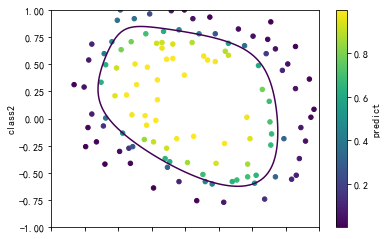

In [36]:
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #增加了sigmoid为激活函数的隐藏层
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=3,
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        if i%10000==0:
#             var_list =tf.get_collection('trainable_variables',scope='network')+[loss]
            _ = sess.run(loss,feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)

0.781873 0.85464996
0.28550002 0.5205145
0.16668887 1.3128357
0.11656834 2.1929893
0.09934766 2.934678
0.09252071 3.9337816
0.08873161 4.758818
0.08659734 5.2791214
0.08526293 6.034591
0.08437831 6.6956086
finish train


(-1, 1)

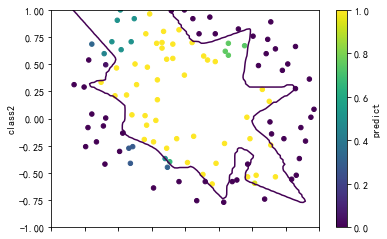

In [74]:
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #增加了sigmoid为激活函数的隐藏层
    #####################################################
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=10,
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
    #####################################################
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        if i%10000==0:
            # var_list =tf.get_collection('trainable_variables',scope='network')+[loss]
            _ = sess.run(loss,feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)

### 控制训练步数 early stoping

1.7334943
0.6701691
0.6421815
0.59852725
0.5446656
0.49174085
0.44674873
0.43317357
finish train


(-1, 1)

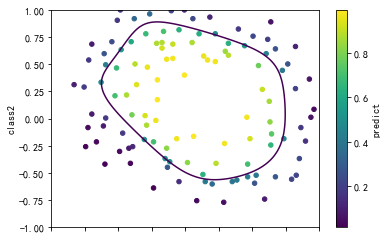

In [22]:
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #增加了sigmoid为激活函数的隐藏层
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=10,
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #####################################################
    # 通过定义一个临时变量，用来监控测试集上loss的变化，当
    # loss不再减小时，停止训练。
    tmp = float('inf')
    #####################################################
    for i in range(100000):
        if i%1000==0:
            _ = sess.run(loss,feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            #####################################################
            if tmp<_:break
            tmp=_
            #####################################################
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)

1.7666477
1.0974907
0.79573274
0.7229387
0.70771897
0.7033955
0.7012843
0.69954187
0.6978175
0.69599795
0.6939398
0.69143444
0.68826336
0.6842845
0.6794184
0.6735848
0.6667021
0.6587679
0.649987
0.6408434
0.63198555
0.62398577
0.61716783
0.61157715
0.60699415
0.6028858
0.59844893
0.5931085
0.58649945
0.5779239
0.5667274
0.55325437
0.538905
0.5252481
0.5132442
0.50310653
0.49464786
0.48745155
0.48084375
0.47504357
0.47094816
0.46851206
0.46709013
0.46604612
0.465186
0.4646383
0.46432632
0.46412107
0.46437523
0.46594653
0.46915329
0.47292104
0.4758243
0.47776258
0.47957495
0.48174477
0.48431143
0.48721075
Early stopping is trigger at step: 11400 loss:0.487210750579834
INFO:tensorflow:Restoring parameters from early_stoping/checkpoint.ckpt
finish train


(-1, 1)

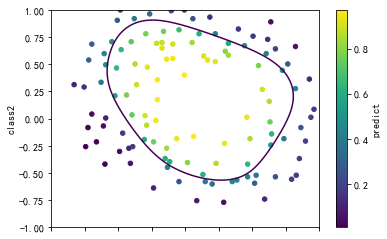

In [18]:
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #增加了sigmoid为激活函数的隐藏层
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=10,
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
train = tf.train.AdamOptimizer().minimize(loss)
##############################################################
best_loss = float('inf')
saver = tf.train.Saver()
early_stopping_step=2000
##############################################################

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        ######################################################################
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
        if i%200==0:
            loss_value = sess.run(loss,feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            if (loss_value < best_loss):
                stopping_step = 0
                best_loss = loss_value
                saver.save(sess,'early_stoping/checkpoint.ckpt')
            else:
                stopping_step += 200
            if stopping_step >= early_stopping_step:
                print("Early stopping is trigger at step: {} loss:{}".format(i,loss_value))
                saver.restore(sess,'early_stoping/checkpoint.ckpt')
                break
        ########################################################################
        
        
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)

### 加入正则化项

1.9574324
0.49430093
0.4615253
0.45184383
0.44693694
0.44671717
0.4464599
0.44659802
0.44665545
0.44685894
finish train


(-1, 1)

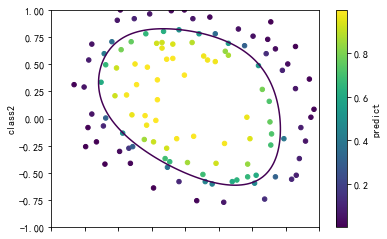

In [80]:
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #增加了sigmoid为激活函数的隐藏层
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=10,
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer,
                                    #####################################################
                                    # 通过增加l1正则化项（l1正则化项是各项可训练参数的绝对
                                    # 值之和），使得一部分作用较小的神经元的权重为0，从而达
                                    # 到简化神经网络的作用，在添加了正则化项之后，还需要在
                                    # loss处（如下所示），将正则化项加入进去。
                                     weights_regularizer=slim.l1_regularizer(0.001),
#                                      biases_regularizer=slim.l1_regularizer(0.001),
                                     scope='hidden_layer')
                                    #####################################################
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
#####################################################
loss += sum(tf.get_collection('regularization_losses'))
#####################################################
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(100000):
        if i%10000==0:
            _ = sess.run(loss,feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)

[0.8361516]
[0.6122475]
[0.51862377]
[0.479687]
[0.46127415]
[0.45173717]
[0.44646496]
[0.44350407]
[0.44154915]
[0.44036916]
finish train


(-1, 1)

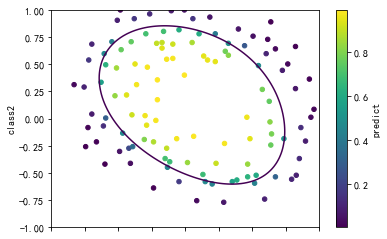

In [73]:
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,2])
y_placeholder = tf.placeholder(tf.float32,shape=[None,1])

with tf.variable_scope('network'):
    #增加了sigmoid为激活函数的隐藏层
    y_hidden = slim.fully_connected(inputs=x_placeholder,
                                     num_outputs=10,
                                     activation_fn=tf.nn.sigmoid,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer,
                                    #####################################################
                                     weights_regularizer=slim.l2_regularizer(0.01),scope='hidden_layer')
                                    #####################################################
    y_predict = slim.fully_connected(inputs=y_hidden,
                                     num_outputs=1,
                                     activation_fn=None,
                                     weights_initializer=tf.random_normal_initializer,
                                     biases_initializer=tf.random_normal_initializer)
loss = slim.losses.sigmoid_cross_entropy(logits=y_predict,multi_class_labels=y_placeholder)
#####################################################
loss += sum(tf.get_collection('regularization_losses'))
#####################################################
train = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(100000):
        if i%10000==0:
            _ = sess.run(loss,feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            print(_)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
    _y_predict = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder:x_data,y_placeholder:y_data})
    x = np.linspace(-1,1,101)
    y = np.linspace(-1,1,101)
    X,Y = np.meshgrid(x,y)
    Z = sess.run(tf.nn.sigmoid(y_predict),feed_dict={x_placeholder: np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])})
print('finish train')

df['predict']=_y_predict
df.plot(kind='scatter',x='class1',y='class2',c='predict',cmap='viridis')
plt.contour(X,Y,Z.reshape([101,101]),0.5)
plt.xlim(-1,1)
plt.ylim(-1,1)